# Random ODE Generator

## Setting Problem Up

In [1]:
### Imports ###
import numpy as np
from sympy import *
import sympy
import random as rand
import IPython.display as disp
init_printing()

In [2]:
### Setting predetermined values ###

# Setting the order of the equation (fixed)
n = 3

########

# Number of y-type terms (x, y, y', etc.)
T = n + 2

# Minimum number of subterms total (total number of terms in the final equation)
min_subterms = 4

# Maximum number of subterms total (total number of terms in the final equation)
max_subterms = 5

# Maximum number of times a function recursively called to create a function
max_fun = 2

# Sets the cumulative probabilities for the following function types:
# (1) No change (2) power (3) exponential (4) logarithmic (5) trig (6) hyperbolic
function_cdf = [0.1, 0.5, 0.62, 0.74, 1, 1]

# Sets the probability that the function creating function will recursively call
# itself again
recurs_prob = 0.1

# The probability of adding a constant to the function
add_c_prob = 0.2

In [3]:
### Defining the symbols, functions, and terms ###

# Define symbol and function variables
x = Symbol('x')

# Stores the y-type terms (x, y, y', etc.) in an array called y_terms
y_terms = np.empty(T, dtype=Symbol)
y_terms[0] = x

for i in range(1, T):
    #y_terms[i] = y(x).diff(x, i - 1)
    y_terms[i] = Symbol('y'+str(i-1))
    
y_terms

array([x, y0, y1, y2, y3], dtype=object)

## Functions

In [4]:
def num_subterms (sum_min, sum_max):
    '''
    This creates an array of the number of subterms for each y-type term.
    If the number of subterms is less than the specified minimum or greater than
    the specified maximum, the function will call itself recursively until
    a valid number of subterms are determined.

    Parameters
    ----------
    sum_min:  int
              The minimum number of total subterms
    sum_max:  int
              The maximum number of total subterms

    Returns
    ----------
    temp: numpy array of int
          Returns the number of subterms for each y-type term
    '''

    temp = np.empty(T, dtype=int)
    # Initially set that the nth derivative term has one subterm
    temp[-1] = 1

    # Set number of subterms (0, 1, or 2) for remaining terms
    for i in range(T - 1):
        # Sets the probability of having 0 subterms or 1 subterm
        probabilities = [0] * 1 + [1] * 2
        temp[i] = rand.choice(probabilities)

    if (sum(temp) < sum_min or sum_min > sum_max):
        return num_subterms (sum_min, sum_max)
    return temp

In [5]:
num_subterms(min_subterms, max_subterms)

array([1, 0, 1, 1, 1])

In [6]:
print(rand.randint(0, 3))

2


In [7]:
# def create_subterm(y_term, cdf, iteration, max_it, const_prob):
def create_subterm(y_term, const_prob):

    '''
    This returns a random subterm (a random function of the given y_term).
    It may recursively call itself to make a more complicated funciton up to
    max_it times.

    The drawable functions include power, exponential, logarithmic,
    trigonometric, and hyperbolic.

    Parameters
    ----------
    y_term:     Object
                The y-type term (x, y, y', etc.)
    cdf:        int
                The cumulative pobability of each function type (power,
                exponential, logarithmic, and trigonometric)
    iteration:  int
                The iteration number (how many times the function has
                been called)
    max_it:     int
                The maximum number of times the function can be called
    const_prob: float
                The probability of adding a constant to the current subterm

    Returns
    ----------
    subterm:  Object
              Returns a subterm for a function of a given y_term
    '''

    # Default value (function does nothing)
    subterm = y_term

    # RETURNING y3 alone
    if y_term == y_terms[4]:
        return y_terms[4]

    # Randomly determines if a function must be applied (and which function)
    temp = rand.random()
    # population = [0, 1, 2, 3]
    # weights = [0.1, 0.25, 0.4, 0.25]
    # temp2 = rand.choices(population, weights)
    temp2 = rand.randint(0, 3)

    # Trig
    if temp2 == 0:
        trig_fun = [sin(y_term)] + [cos(y_term)] + [tan(y_term)]
        subterm = rand.choice(trig_fun)
    # Log
    elif temp2 == 1:
        subterm = log(y_term+1)
    # Exponential
    elif temp2 == 2:
        subterm = exp(y_term)
    # Power
    elif temp2 == 3:
        # Random positive power from 1 to 4
        fun_power = rand.randint(1, 4)
        subterm = (y_term)**(fun_power)

    # Determines coefficient; the sign will already be either positive or negative
    coeffs = np.linspace(-5,-1,5, dtype=int)
    if rand.random() < 0.5:
        subterm *= rand.choice(coeffs)
    elif rand.random() > 0.5:
        subterm /= rand.choice(coeffs)

    # Determines added constant
    if rand.random() < const_prob:
        subterm += rand.choice(coeffs)

    return simplify(subterm)

In [8]:
def create_subterms(y_terms):
    '''
    This returns all subterms of the equation.

    Parameters
    ----------
    y_terms:   numpy array of Object
              The y-type terms (x, y, y', etc.)
    num_sub:  numpy array of int
              The number of subterms for each y-type term

    Returns
    ----------
    subterms: numpy array of Object
              Returns all of the subterms for the equation
    '''

    subterms = []
    for i in y_terms:
        subterms.append(create_subterm(i, add_c_prob))
    
    nonlinear_term = rand.choice(subterms[1:])
    # possible_choices = [v for v in subterms[1:] if v != nonlinear_term]
    # coefficient_term = rand.choice(possible_choices)
    coefficient_term = rand.choice(y_terms[1:4])

    subterms = [nonlinear_term * coefficient_term if subterm == nonlinear_term else subterm for subterm in subterms]

    return subterms

## Final Calculation and Output

In [9]:
print(y_terms)
terms = create_subterms(y_terms)
print("The terms are:")
for i in range(len(terms)):
    disp.display(terms[i])
    print()

[x y0 y1 y2 y3]
The terms are:


In [10]:
sum(terms)

In [11]:
# Define y3 from y_terms
y3 = y_terms[4]
solve(sum(terms),y3)

# Dominant Balance Solver

## All helper functions for solver


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from sympy import *
init_printing()
from sympy.utilities.lambdify import lambdify, implemented_function

In [13]:
# SOLVER (depending on which order it is, we would have to use different fun)
# the following is an example for third order

# define a function to convert sympy to numpy functions
def sym_convert(eq):
  return lambdify([y0,y1,y2,y3,x], eq)

# here, we define the compiled solver
def main_solver(odeterms, a, b, init_condition):

  # i am not sure if this is necessary since the input is already sympy exp?
  x,y1,y2,y0,y3 = symbols('x y1 y2 y0 y3')

  # generate equation and y3 expression
  eq = sum(odeterms)
  y3 = solve(eq,y3)[0]

  # generate function to put into odesystem
  lam_y = lambdify([y0,y1,y2,x], [y1, y2, y3])
  lam_y3 = lambdify([y0,y1,y2,x], y3)

  # solve the ode
  y_init = init_condition
  y_sol = ode3_solver(lam_y, a, b, y_init)

  # generate numerical solution for y3
  y3_sol = lam_y3(y_sol[1,:], y_sol[2,:], y_sol[3,:], y_sol[0,:])
  y_compiled = np.vstack((y_sol,y3_sol))

  return y_compiled

# define divergence event for when solve_ivp should terminate
def div_event(t,y):
    return abs(y[0]) - 1e3

div_event.terminal = True

def ode3_solver(lam_y, a, b, y_init):
  # we define an ODE function to pass into the integrator
  def ode_y(x,y):
    y0,y1,y2 = y
    return lam_y(y0,y1,y2,x)

  # determine integration steps
  t = np.linspace(a,b, num=int((b-a)*10+1))

  # integrate to find y solutiont
  print(y_init)
  soln = solve_ivp(ode_y,[a,b],y_init,t_eval=t,events=div_event)

  y_sol = np.vstack((soln.t,soln.y))

  return y_sol

def ode2_solver(lam_y, a, b, y_init):
  # we define an ODE function to pass into the integrator
  def ode_y(x,y):
    y0,y1 = y
    return lam_y(y0,y1,x)

  # determine integration steps
  t = np.linspace(a,b, num=int((b-a)*10+1))

  # integrate to find y solution
  print(y_init)
  soln = solve_ivp(ode_y,[a,b],y_init,t_eval=t,events=div_event)

  y_sol = np.vstack((soln.t,soln.y))

  return y_sol

def ode1_solver(lam_y, a, b, y_init):
  # we define an ODE function to pass into the integrator
  def ode_y(x,y):
    y0 = y
    return lam_y(y0,x)

  # determine integration steps
  t = np.linspace(a,b, num=int((b-a)*10+1))

  # integrate to find y solution
  print(y_init)
  soln = solve_ivp(ode_y,[a,b],y_init,t_eval=t,events=div_event)

  y_sol = np.vstack((soln.t,soln.y))

  return y_sol


# define the dom balance function
def dom_bal(odeterms, sol, x):
  """
  1. input odeterms as a list of sympy expressions of the terms
  2. input sol as the numerical sol obtained from solver
  3. input x as linspace array of the x domain
  """
  # array to store the dominant balance values
  absterms = np.zeros((len(odeterms), len(x)))
  domterms = np.zeros((2, len(x)))

  # generate abs value of each term
  for idx, term in enumerate(odeterms):
    abs_eq = sym_convert(term)
    absterms[idx,:] = abs(abs_eq(sol[0,:], sol[1,:], sol[2,:], sol[3,:], x))

  # iterate through to determine dominant balance throughout the domain
  for i in range(len(x)):
    domterms[:,i] = np.argsort(absterms[:,i])[-2:]

  return absterms, domterms

def dom_sol(domterms, a, b, y_init):
  x,y1,y2,y0,y3 = symbols('x y1 y2 y0 y3')
  # determine which y terms are in the dom bal terms

  for term in domterms:
    if y3 in term.free_symbols:
      eq = sum(domterms)
      y3 = solve(eq,y3)[0]
      lam_y = lambdify([y0,y1,y2,x], [y1, y2, y3])

      # solve the ode
      y_compiled = ode3_solver(lam_y, a, b, y_init)

      return y_compiled

  for term in domterms:
    if y2 in term.free_symbols:
      eq = sum(domterms)
      y2 = solve(eq,y2)[0]
      lam_y = lambdify([y0,y1,x], [y1, y2])
      lam_y2 = lambdify([y0,y1,x], y2)

      # solve the ode
      y_sol = ode2_solver(lam_y, a, b, y_init[0:2])

      # generate numerical solution for y2
      y2_sol = lam_y2(y_sol[1,:], y_sol[2,:], y_sol[0,:])
      y_compiled = np.vstack((y_sol,y2_sol))

      return y_compiled

  for term in domterms:
    if y1 in term.free_symbols:
      eq = sum(domterms)
      y1 = solve(eq,y1)[0]
      lam_y = lambdify([y0,x], [y1])
      lam_y1 = lambdify([y0,x], y1)

      # solve the ode
      y_sol = ode1_solver(lam_y, a, b, [y_init[0]])

      # generate numerical solution for y1
      y1_sol = lam_y1(y_sol[1,:], y_sol[0,:])

      # generate numerical solution for y2 using finite difference
      y2_sol = np.zeros(len(y1_sol))
      y2_sol[-1] = (y1_sol[-1] - y1_sol[-2])/(y_sol[0,-1] - y_sol[0,-2])

      y_compiled = np.vstack((np.vstack((y_sol,y1_sol)),y2_sol))
      return y_compiled

  for term in domterms:
    if y0 in term.free_symbols:
      eq = sum(domterms)
      y0 = solve(eq,y0)[0]

      # create y function and timesteps
      lam_y = lambdify(x, y0)
      t = np.linspace(a,b,num=int((b-a)*10 + 1))

      # solve y function
      y_sol = lam_y(t)
      print("ysol is " , y_sol)
      # generate numerical solution for y1 using finite difference
      y1_sol = np.zeros(len(y_sol))

      y2_sol = np.zeros(len(y1_sol))
      if len(y_sol) > 2:
        y1_sol[-2] = (y_sol[1,-2] - y_sol[1,-3])/(y_sol[0,-2] - y_sol[0,-3])
        y1_sol[-1] = (y_sol[1,-1] - y_sol[1,-2])/(y_sol[0,-1] - y_sol[0,-2])

        # generate numerical solution for y2 using finite difference

        y2_sol[-1] = (y1_sol[-1] - y1_sol[-2])/(y_sol[0,-1] - y_sol[0,-2])

      y_compiled = np.vstack((np.vstack((y_sol,y1_sol)),y2_sol))

      return y_compiled

In [14]:
def get_regimes(domterms):
  leaders = {domterms[0,0],domterms[1,0]}
  regimes = np.array(['start index','end index',{'term1','term2'}])
  start_index = 0
  for i in range(domterms.shape[1]):
    if {domterms[0,i],domterms[1,i]} != leaders:
      regimes = np.vstack((regimes,[start_index,i-1,leaders]))
      leaders = {domterms[0,i],domterms[1,i]}
      start_index = i-1
  regimes = np.vstack((regimes,[start_index,domterms.shape[1]-1,leaders]))
  return regimes

In [15]:
def verifier(soln, dom_bal, start_regime, squared_error):
  """
  inputs to pass in: solution (of y), dom balance solution (of y), beginning index of regime in soln
  """
  mre = 0
  n = len(dom_bal)
  for i in range(n):
    # squared error version
    if squared_error:
      mre += ((soln[start_regime+i]-dom_bal[i])/(soln[start_regime+i]))**2
    else:
      mre += np.abs(soln[start_regime+i]-dom_bal[i])/np.abs(soln[start_regime+i])
  mre = mre/n
  return mre

## Generate Problem Statement in Latex

In [26]:
# Get initial conditions between -1 and 1 uniformly
init_condition = (2 * np.random.random_sample((3,)) - 1)

# Get equation for
x,y1,y2,y0,y3 = symbols('x y1 y2 y0 y3')
terms = create_subterms(y_terms)


# Define the mapping for replacement
replacement_mapping = {
    y0: y0,
    y1: y0.diff(x),
    y2: y0.diff(x, 2),
    y3: y0.diff(x, 3)
}

# Function to replace y0, y1, y2 with y, y', y''
def replace_with_differential(expr):
    return expr.subs(replacement_mapping)

replaced_expr = replace_with_differential(solve(sum(terms),y3)[0])

print(disp.display(replaced_expr))

# Converting the replaced expression to LaTeX
latex_replaced_expr = latex(replaced_expr)

# Extracting the values a, b, c from init_condition
a, b, c = init_condition

# Preparing the updated LaTeX formatted equation with x_0 as 0 and the new form of the equation
updated_latex_equation = f"""
\\text{{Given the third-order ODE: }} y''' = {latex_replaced_expr}

\\text{{With initial conditions at }} x = 0:
\\begin{{align*}}
y(0) &= {a:.2f} \\\\
y'(0) &= {b:.2f} \\\\
y''(0) &= {c:.2f}
\\end{{align*}}
"""

updated_latex_equation

None


"\n\\text{Given the third-order ODE: } y''' = 4 - x^{3}\n\n\\text{With initial conditions at } x = 0:\n\\begin{align*}\ny(0) &= 0.40 \\\\\ny'(0) &= 0.08 \\\\\ny''(0) &= -0.22\n\\end{align*}\n"

[-0.65924113 -0.63491627  0.08326271]
t_stop is  0.5
T step is  0.1
[['start index' 'end index' {'term1', 'term2'}]
 [0 2 {2.0, 3.0}]
 [2 3 {0.0, 3.0}]
 [3 5 {0.0, 4.0}]]
[-0.65924113 -0.63491627]
[-0.65924113 -0.63491627]
[-0.65924113 -0.63491627]
[-0.65924113 -0.63491627]
[-0.65924113 -0.63491627  5.63665074]
[-0.65924113 -0.63491627  5.63665074]


<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in log
  return [y1, y2, 2*y1*cos(y2) + 2*exp(y1) + (1/5)*log(y0 + 1) + 5*tan(x)]
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in arccos
  return [y1, -arccos(-exp(y1)/y1) + 2*pi]
<lambdifygenerated-10>:2: RuntimeWarning: invalid value encountered in arccos
  return [y1, -arccos(-exp(y1)/y1) + 2*pi]
<lambdifygenerated-12>:2: RuntimeWarning: invalid value encountered in arccos
  return [y1, -arccos(-5/2*tan(x)/y1) + 2*pi]
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in arccos
  return [y1, -arccos(-5/2*tan(x)/y1) + 2*pi]


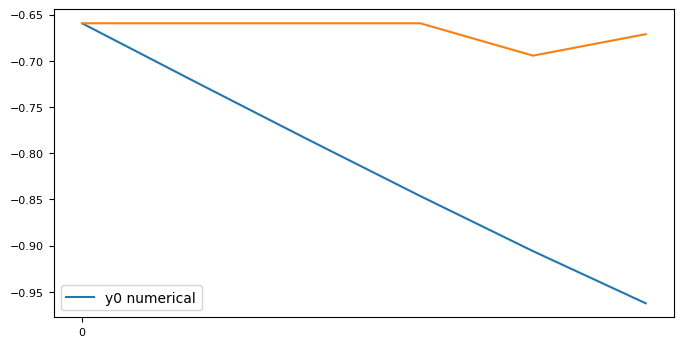

In [17]:
soln = main_solver(terms,0,10,init_condition)

# Get the point at which it terminated
t_stop = soln[0,soln.shape[1]-1]
print("t_stop is ", t_stop)

# Get the t-step
t_step = soln[0,1]-soln[0,0]
print("T step is ",t_step)

# Graph it!
plt.figure(figsize=(8,4))
plt.plot(soln[0,],soln[1,],label='y0 numerical')
plt.legend()
plt.xticks(np.arange(0, t_stop,step=0.5))
plt.tick_params(axis='both', which='major', labelsize=8)

# Get the dominant balances
x,y1,y2,y0,y3 = symbols('x y1 y2 y0 y3')
absterms, domterms = dom_bal(terms, soln[1:5,:], soln[0,:])

# Get the regimes
regimes = get_regimes(domterms)
print(regimes)

# Iterate through regimes
regime_init = init_condition
regimes_soln = np.zeros(soln.shape[1])
regimes_soln[0] = init_condition[0]
for reg_num in range(1,len(regimes)):
  start_idx = regimes[reg_num][0]
  end_idx = regimes[reg_num][1]
  if start_idx != end_idx:
    start_t = 0.1*start_idx
    end_t = 0.1*end_idx
    winner_0 = int(list(regimes[reg_num][2])[0])
    winner_1 = int(list(regimes[reg_num][2])[1])
    regime_solved = dom_sol([terms[winner_0],terms[winner_1]],a=start_t,b=end_t,y_init=regime_init)
    if len(regime_solved[1,]) != len(regimes_soln[start_idx:end_idx+1]):
      regime_solved = dom_sol([terms[winner_0],terms[winner_1]],a=round(start_t,1),\
                              b=round(end_t,1),y_init=regime_init)
    regimes_soln[start_idx:end_idx+1] = regime_solved[1,]
    regime_init = regime_solved[1:,-1]

plt.plot(soln[0,],regimes_soln,label='dominant balances')

In [18]:
#MRE
round(100*verifier(soln[1,],regimes_soln,0,False),3)

In [19]:
#Number of regimes
len(regimes)-1